In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline

In [5]:
def download_mnist_csv():
    base_url = "https://pjreddie.com/media/files/"
    files = {"train": "mnist_train.csv", "test": "mnist_test.csv"}
    print("Downloading MNIST CSV files...")
    for dataset, filename in files.items():
        url = base_url + filename
        try:
            urlretrieve(url, filename)
            print(f"Downloaded {filename}")
        except Exception as e:
            print(f"Error downloading {filename}: {e}")
    return files

# Download the files
files = download_mnist_csv()

Downloaded mnist_train.csv
Downloaded mnist_test.csv


In [9]:
def clean_mnist_data(df):
    pixel_cols = df.columns[1:]
    invalid_pixels = (df[pixel_cols] < 0) | (df[pixel_cols] > 255)
    print(f"Number of invalid pixel values: {invalid_pixels.sum().sum()}")
    invalid_labels = (df[0] < 0) | (df[0] > 9)
    print(f"Number of invalid labels: {invalid_labels.sum()}")
    df[pixel_cols] = df[pixel_cols].clip(0, 255)
    clean_df = df[~invalid_labels]
    print(f"Removed {len(df) - len(clean_df)} rows with invalid labels")
    return clean_df

# Load data
train_df = pd.read_csv(files["train"], header=None)
test_df = pd.read_csv(files["test"], header=None)

# Clean data
train_df_clean = clean_mnist_data(train_df)
test_df_clean = clean_mnist_data(test_df)

# Extract features and labels
X_train_full = train_df_clean.iloc[:, 1:].values
y_train_full = train_df_clean.iloc[:, 0].values
X_test = test_df_clean.iloc[:, 1:].values
y_test = test_df_clean.iloc[:, 0].values

# Use a subset of training data
subset_size = 10000  # 10,000 samples for faster training
indices = np.random.choice(len(X_train_full), subset_size, replace=False)
X_train = X_train_full[indices]
y_train = y_train_full[indices]

Number of invalid pixel values: 0
Number of invalid labels: 0
Removed 0 rows with invalid labels
Number of invalid pixel values: 0
Number of invalid labels: 0
Removed 0 rows with invalid labels


In [11]:
print("Dataset Exploration (subset):")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Image dimensions: {int(np.sqrt(X_train.shape[1]))}x{int(np.sqrt(X_train.shape[1]))}")
print("\nLabel distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for digit, count in zip(unique, counts):
    print(f"Digit {digit}: {count} samples")
print(f"Pixel value range: [{X_train.min()}, {X_train.max()}]")
print(f"Mean pixel value: {X_train.mean():.2f}")

Dataset Exploration (subset):
Training set shape: (10000, 784)
Test set shape: (10000, 784)
Image dimensions: 28x28

Label distribution in training set:
Digit 0: 962 samples
Digit 1: 1116 samples
Digit 2: 973 samples
Digit 3: 1061 samples
Digit 4: 927 samples
Digit 5: 906 samples
Digit 6: 1030 samples
Digit 7: 1061 samples
Digit 8: 986 samples
Digit 9: 978 samples
Pixel value range: [0, 255]
Mean pixel value: 33.16


Sample images from training set:


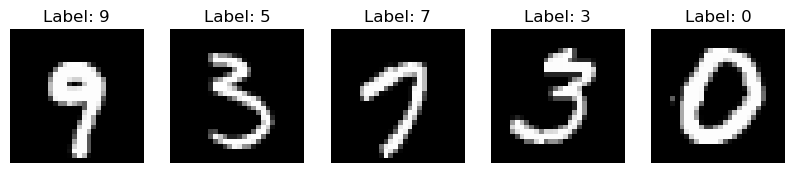

In [13]:
def plot_sample_images(X, y, num_samples=5):
    plt.figure(figsize=(10, 2))
    random_indices = np.random.choice(len(X), num_samples, replace=False)
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_samples, i+1)
        img = X[idx].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {y[idx]}")
        plt.axis('off')
    plt.show()

print("Sample images from training set:")
plot_sample_images(X_train, y_train)

In [15]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data scaling completed!")

Data scaling completed!


In [17]:
# Define models
lr_model = LogisticRegression(max_iter=1000, random_state=42)
svm_model = SGDClassifier(loss='hinge', max_iter=1000, random_state=42)  # Linear SVM
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
ensemble_model = VotingClassifier(
    estimators=[('lr', lr_model), ('svm', svm_model), ('rf', rf_model)],
    voting='hard'
)

# Train models
print("Training models...")
for model, name in [(lr_model, "Logistic Regression"), 
                    (svm_model, "Linear SVM"), 
                    (rf_model, "Random Forest"), 
                    (ensemble_model, "Ensemble")]:
    model.fit(X_train_scaled, y_train)
    print(f"{name} trained successfully!")

Training models...
Logistic Regression trained successfully!


C:\Users\lesle\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Linear SVM trained successfully!
Random Forest trained successfully!


C:\Users\lesle\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Ensemble trained successfully!


In [19]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    return accuracy

# Evaluate all models
accuracies = {}
for model, name in [(lr_model, "Logistic Regression"), 
                    (svm_model, "Linear SVM"), 
                    (rf_model, "Random Forest"), 
                    (ensemble_model, "Ensemble")]:
    accuracies[name] = evaluate_model(model, X_test_scaled, y_test, name)


Logistic Regression Results:
Accuracy: 0.8862
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       980
           1       0.95      0.97      0.96      1135
           2       0.87      0.85      0.86      1032
           3       0.83      0.89      0.86      1010
           4       0.89      0.89      0.89       982
           5       0.83      0.81      0.82       892
           6       0.91      0.92      0.91       958
           7       0.90      0.89      0.90      1028
           8       0.84      0.81      0.83       974
           9       0.88      0.87      0.87      1009

    accuracy                           0.89     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.89      0.89      0.89     10000


Linear SVM Results:
Accuracy: 0.9011
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       980
 

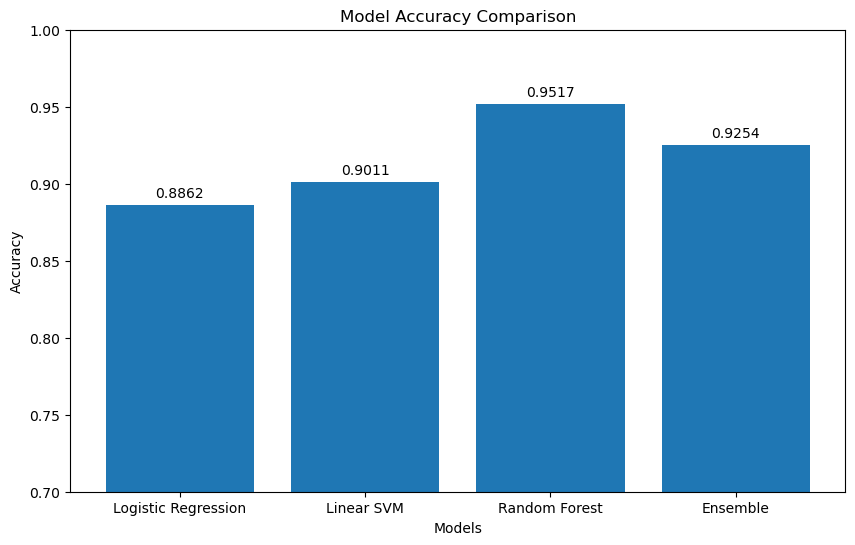

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
for i, (name, acc) in enumerate(accuracies.items()):
    plt.text(i, acc + 0.005, f'{acc:.4f}', ha='center')
plt.show()